In [ ]:
#Import/Install Packages
import datetime
import os
import requests
import time
import matplotlib as mt
import imageio
      
!pip install --quiet geopandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 23.3 MB/s eta 0:00:00


In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray

#Install mapping packages
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Set root URL for API requests
root_url = 'https://api.climateengine.org/'
# Authentication info for the API (INSERT YOUR OWN KEY)
headers = {'Authorization': 'INSERT YOUR API KEY HERE'}
# Google Storage bucket for storing output files (INSERT YOUR OWN BUCKET)
bucket_name = 'INSERT YOUR BUCKET HERE'

In [ ]:
#Define Bounding Box 

#Bring in spatial file of interest (GeoJSON, SHP) 
df = gpd.read_file('/content/Continental_US.shp')

 #Generate a bounding box around AOI
bbox = df.bounds

#Get values from box
sw_long = round(bbox.iat[0,0], 6)
sw_lat = round(bbox.iat[0,1], 6)
ne_long = round(bbox.iat[0,2], 6)
ne_lat = round(bbox.iat[0,3], 6)

#Generate Bounding Box Coordinates String
allot_bbox = [sw_long,sw_lat,ne_long,ne_lat]

print(allot_bbox)

[-124.725839, 24.498131, -66.949895, 49.384358]


In [ ]:
#Create List for Dates to Iterate Through
startDates =['2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01']
endDates = ['2022-01-31','2022-02-28','2022-03-31','2022-04-30','2022-05-31','2022-06-30','2022-07-31','2022-08-31','2022-09-30','2022-10-31','2022-11-30','2022-12-31']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fileNames = []

In [ ]:
#Create Function to Export Monthly Mean Images for LST
def export_images(start_date, end_date, month):
 
 #Raster Export Endpoint
  endpoint = 'raster/export/values'

  # No need to include an extension on the export_filename below, .tif will be appended automatically.
  Export_filename = 'LST_' + month
  fileNames.append(Export_filename)

  #Set up Paramters for API call
  params = {
      'dataset': 'MODIS_TERRA_8DAY',
      'variable': 'LST_Day_1km',
      'temporal_statistic':'mean',
      'start_date': start_date,
      'end_date': end_date,
      'bounding_box': f'{allot_bbox}',
      'export_path': f'{bucket_name}/{Export_filename}'
  }
  # Send request to the API (If you already have tiffs in bucket, comment out next two lines)
  r = requests.get(root_url + endpoint, params=params, headers=headers, verify=True)
  response = r.json()

  print("Geotiff Request made for " + month)


In [ ]:
for i in range(12):
      export_images(startDates[i],endDates[i], months[i])

Geotiff Request made for Jan
Geotiff Request made for Feb
Geotiff Request made for Mar
Geotiff Request made for Apr
Geotiff Request made for May
Geotiff Request made for Jun
Geotiff Request made for Jul
Geotiff Request made for Aug
Geotiff Request made for Sep
Geotiff Request made for Oct
Geotiff Request made for Nov
Geotiff Request made for Dec


In [ ]:
print(fileNames)

['LST_Jan', 'LST_Feb', 'LST_Mar', 'LST_Apr', 'LST_May', 'LST_Jun', 'LST_Jul', 'LST_Aug', 'LST_Sep', 'LST_Oct', 'LST_Nov', 'LST_Dec']


In [ ]:
#Connect to GCS
#Get access to Google Cloud Storage Bucket 
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'INSERT YOUR GOOGLE PROJECT ID HERE'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
#Bring in Rasters from GCS
# Download the file from a given Google Cloud Storage bucket.
for j in fileNames:
  !gsutil cp gs://{bucket_name}/{j}.tif /content/{j}.tif

In [ ]:
#Write Function to read in raster, create map, export 
def map_maker(raster):
  #Read in Raster
  file_path = f'/content/{raster}.tif'
  rds = rxr.open_rasterio(file_path)

  #Generate Map
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 13)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(rds[0], cmap ='RdYlBu_r',vmin =-10, vmax = 45)
  ax. set_frame_on(False)
  

  # Hide X and Y axes label marks
  ax.xaxis.set_tick_params(labelbottom=False)
  ax.yaxis.set_tick_params(labelleft=False)

  # Hide X and Y axes tick marks
  ax.set_xticks([])
  ax.set_yticks([])
                       
  #Add Color Bar
  fig.colorbar(im, cax = cax, orientation = 'vertical')

  # create an annotation for the year by grabbing the first 4 digits
  only_month = raster[4:]
  # position the annotation to the bottom left
  ax.annotate(only_month,
          xy=(0.7,.2), xycoords='axes pixels',
          horizontalalignment='left', verticalalignment='top',
          fontname='DejaVu Serif', fontsize=20)
                                     
  #Add Title
  ax.set_title('2022 Land Surface Temperature (Deg C) - MODIS Terra 8-Day', fontname='DejaVu Serif', fontsize =20)
   
  #Add Figure Export Option
  plt.savefig(f'/content/MODIS_{raster}.png', bbox_inches='tight')
         
  #Show Map
  plt.show()


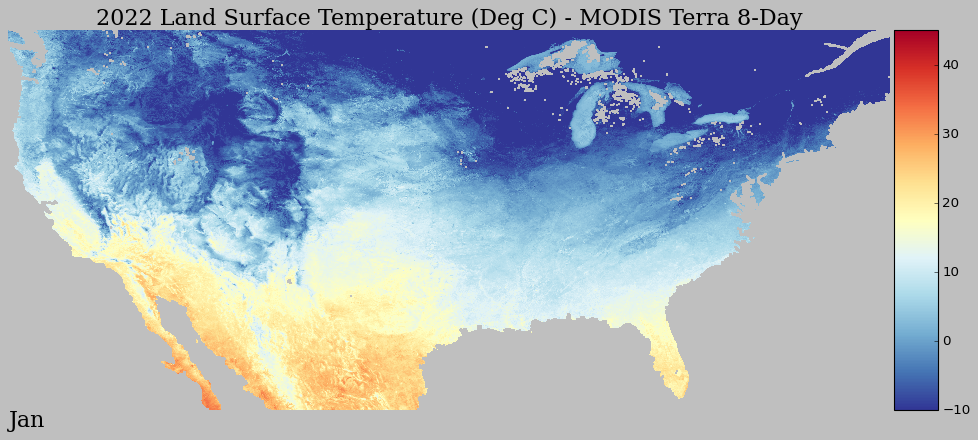

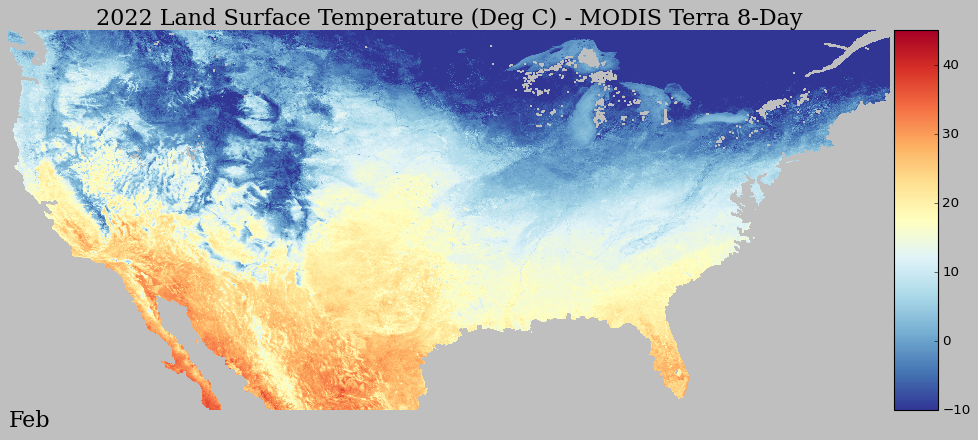

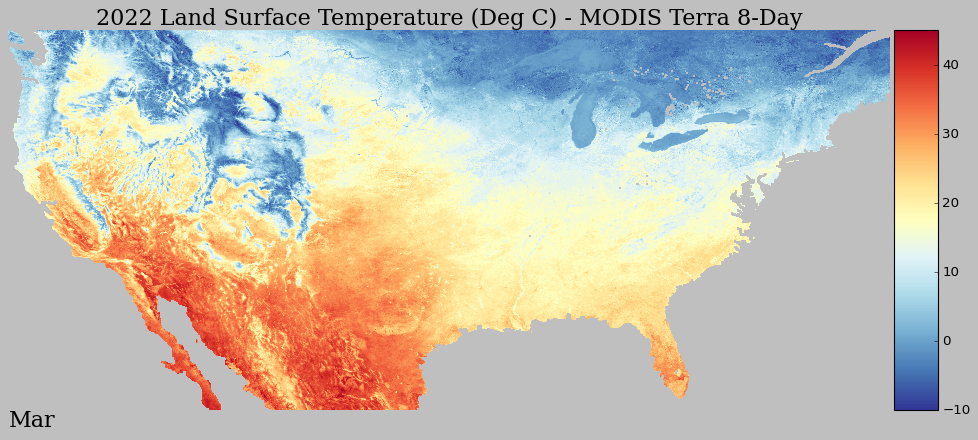

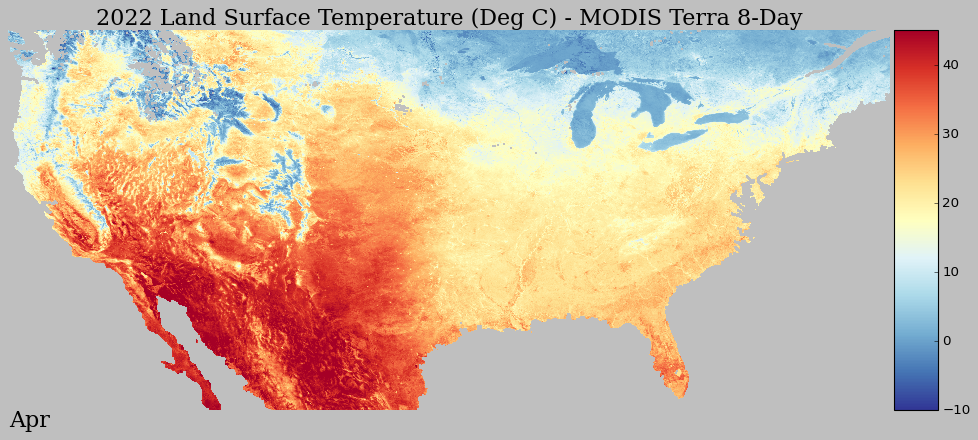

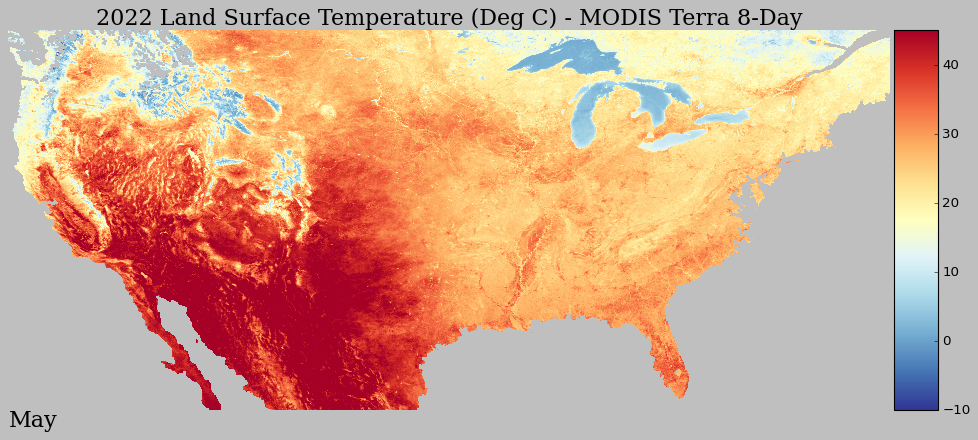

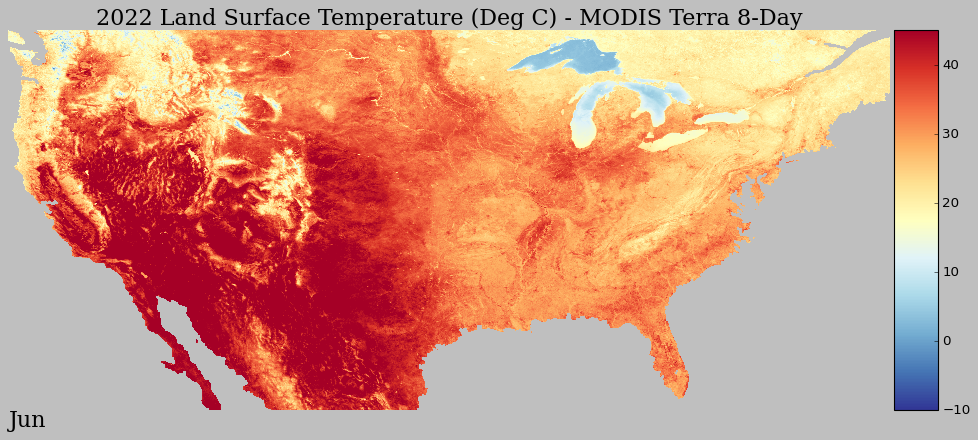

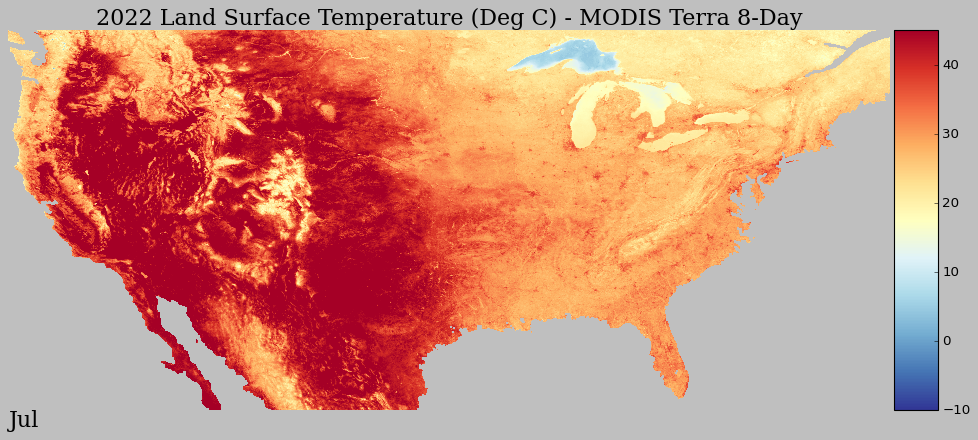

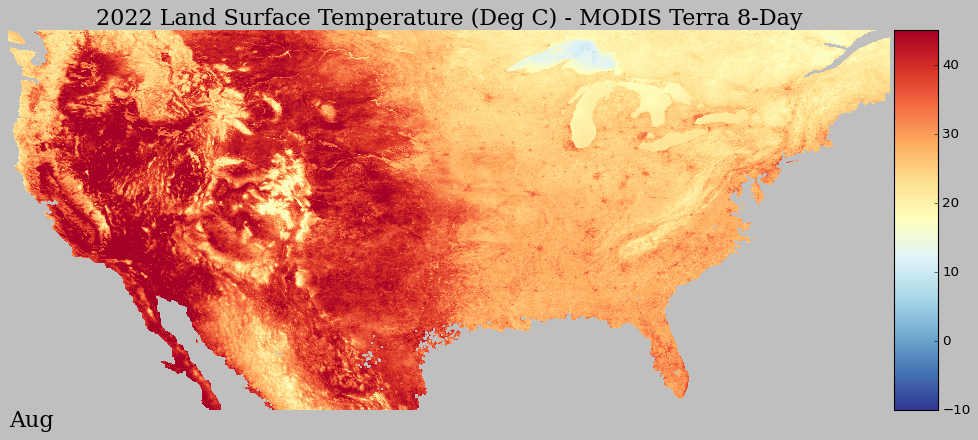

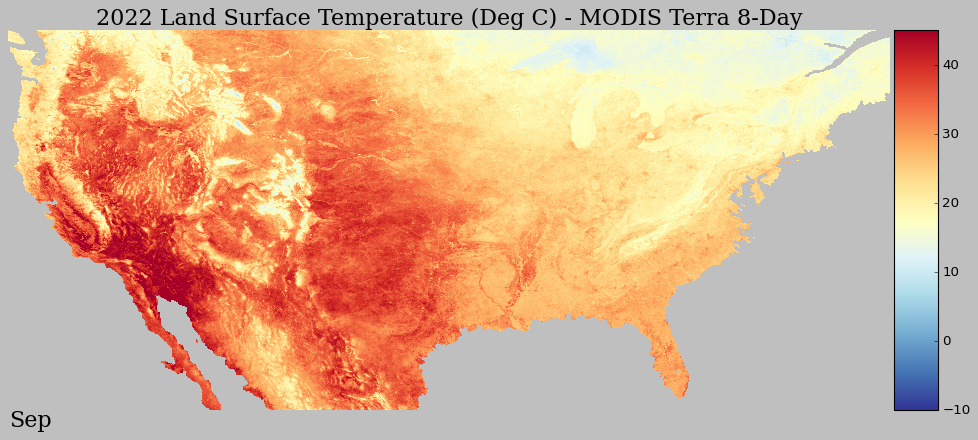

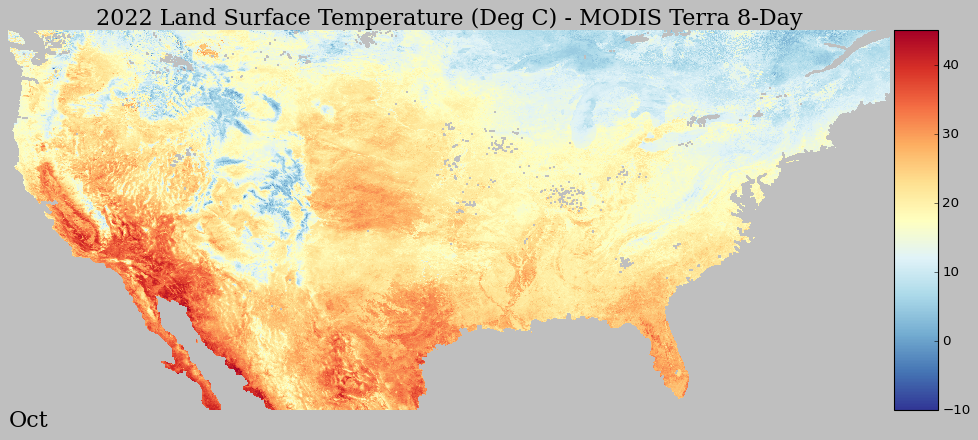

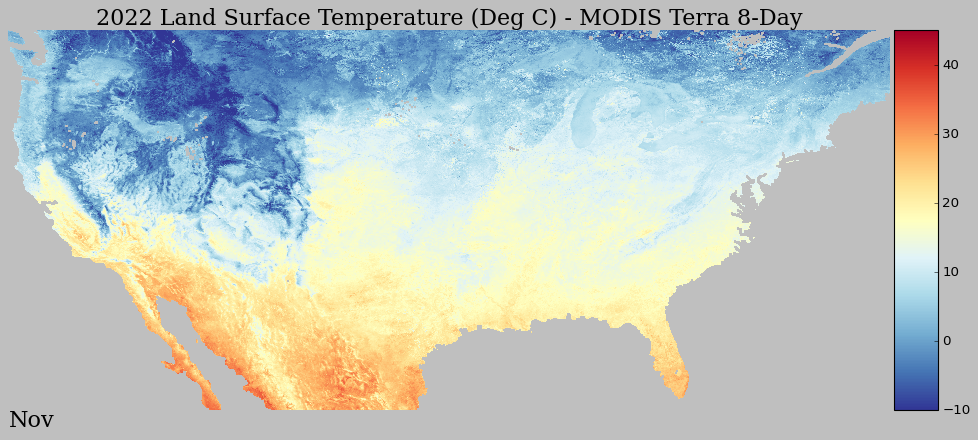

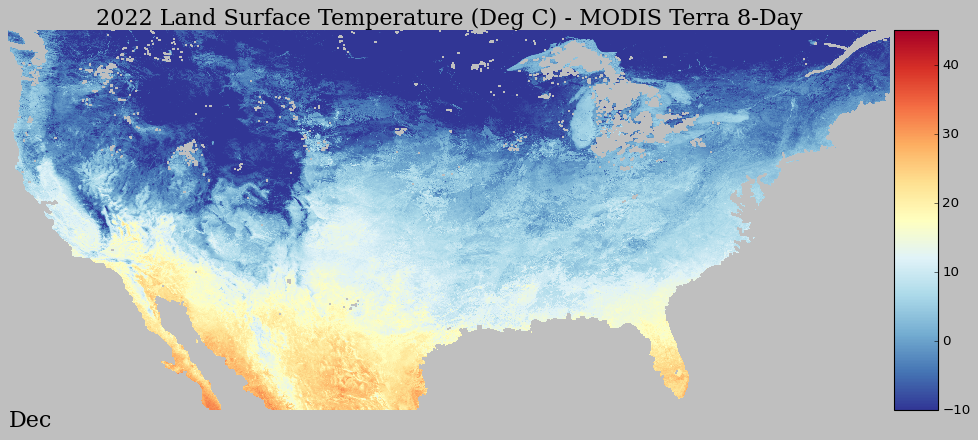

In [ ]:
for j in fileNames:
  map_maker(j)

In [ ]:
import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
print(font_names)

In [ ]:
frames = []
for k in fileNames:
    image = imageio.v2.imread(f'/content/MODIS_{k}.png')
    frames.append(image)

In [ ]:
imageio.mimsave('/content/LST_GIF_V4.mp4', # output gif
                frames,          # array of input frames
                fps = 1#,         # optional: frames per second
                #loop = 1
                )   

In [ ]:
out_file_name = '/content/LST_GIF_V4'
os.system(f'ffmpeg -i {out_file_name}.mp4 {out_file_name}.gif')

0